# Notebook Dedicado a construir un 1er Modelo de ML para Analisar imagenes de eventos

Regimes de prueba:

- [2,4] MeV (hecho)
- [4,6] MeV (hecho)
- [2,10] MeV (hecho)


In [50]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle

In [20]:
# Funcion para generar colores
import colorsys

def create_variants(base_color_rgb):
    # Convertir RGB a HLS
    base_color_hls = colorsys.rgb_to_hls(*base_color_rgb)
    
    # Crear una variante más clara (aumentando la luminosidad)
    lighter_color_hls = (base_color_hls[0], min(1, base_color_hls[1] * 1.5), base_color_hls[2])
    lighter_color_rgb = colorsys.hls_to_rgb(*lighter_color_hls)
    
    # Crear una variante más oscura (disminuyendo la luminosidad)
    darker_color_hls = (base_color_hls[0], base_color_hls[1] * 0.5, base_color_hls[2])
    darker_color_rgb = colorsys.hls_to_rgb(*darker_color_hls)
    
    return lighter_color_rgb, darker_color_rgb

# Colores base
colors = {
    'rojo': (1.0, 0.0, 0.0),
    'azul': (0.0, 0.0, 1.0)
}

# Crear variantes
variants = {color: create_variants(rgb) for color, rgb in colors.items()}

# 1 - Load Data

In [68]:
image_dim = (10, 10)
df_train = shuffle(pd.read_csv("Data/High Stat/Elegant Data Frame Structure/train/df_reduced_5500_10_(2.5_14)_(-5_7).csv"))
df_test = shuffle(pd.read_csv("Data/High Stat/Elegant Data Frame Structure/test/df_test_5500_10_(2.5_14)_(-5_7).csv"))

In [22]:
df_train.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,...,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000
mean,48101.820329,0.106513,0.090626,0.099528,0.103548,0.103828,0.103830,0.104008,0.104136,0.104236,...,0.098086,0.098368,0.098475,0.099130,0.099680,0.100807,5.568478,4082.295650,0.690180,0.309820
std,32598.203125,0.258851,0.216833,0.196060,0.174377,0.154222,0.138390,0.125238,0.113282,0.102508,...,0.148719,0.133906,0.121533,0.110540,0.100627,0.092076,2.311816,1075.312387,0.462421,0.462421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500081,66.302811,0.000000,0.000000
25%,21011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.030303,...,0.000000,0.000000,0.000000,0.021277,0.028169,0.034483,3.657920,3403.060547,0.000000,0.000000
50%,42022.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.048780,0.057143,0.064815,0.071429,...,0.031250,0.045455,0.052632,0.058824,0.066667,0.073171,4.641886,4315.275391,1.000000,0.000000
75%,73989.500000,0.000000,0.000000,0.125000,0.142857,0.150000,0.152174,0.151515,0.150000,0.148649,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,7.421789,4963.363525,1.000000,1.000000
max,116012.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.896552,0.816327,0.828571,...,1.000000,1.000000,0.869565,0.791667,0.840000,0.818182,13.546737,5499.991211,1.000000,1.000000


In [23]:
df_test.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,...,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000
mean,17359.500000,0.101851,0.088344,0.097730,0.101526,0.101727,0.102524,0.102622,0.102860,0.103883,...,0.100303,0.101453,0.101331,0.102479,0.103141,0.104153,4.422798,4106.450430,0.500000,0.500000
std,10022.872839,0.253715,0.217223,0.196499,0.175413,0.155141,0.140647,0.127167,0.115781,0.106405,...,0.150548,0.136830,0.123813,0.113874,0.104076,0.095627,1.584180,1069.562697,0.500004,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500030,106.154373,0.000000,0.000000
25%,8679.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.028571,...,0.000000,0.000000,0.000000,0.022727,0.029412,0.034483,3.444127,3433.930725,0.000000,0.000000
50%,17359.500000,0.000000,0.000000,0.000000,0.000000,0.025641,0.047619,0.055556,0.062500,0.068966,...,0.032258,0.048780,0.055556,0.062500,0.069767,0.075000,3.877555,4347.353271,0.500000,0.500000
75%,26039.250000,0.000000,0.000000,0.111111,0.142857,0.142857,0.150000,0.150000,0.148148,0.148148,...,0.142857,0.148148,0.146341,0.148148,0.147953,0.147059,4.789484,4983.035156,1.000000,1.000000
max,34719.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.875000,0.814815,0.766667,...,1.000000,0.909091,0.909091,0.774194,0.821429,0.708333,13.663218,5499.971680,1.000000,1.000000


# 2 - Data Preprocesing

## 2.1 - Extract Information

In [285]:
pixel_pattern = r'^pixel_\d+$'
energy_cut_train = 12
energy_cut_test = 12

### Extracting training Data

In [286]:
#Separate signal from background 
dataset_sig_train = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_bkg_train = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

#cut in solar energy
dataset_sig_train = (dataset_sig_train[dataset_sig_train['energy (MeV)'] <= energy_cut_train])

#Igualar cantidad de datos de neutrinos solares y de Tálio
N_solar_ev = dataset_sig_train.shape[0]
N_Tl_ev = dataset_bkg_train.shape[0]

if N_solar_ev > N_Tl_ev:
    dataset_sig_train = (dataset_sig_train.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])

else:
    dataset_bkg_train = (dataset_bkg_train.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])
    
#Separate Features for signal and background
df_pixel_sig_train = dataset_sig_train.filter(regex=pixel_pattern)
df_energy_sig_train = (dataset_sig_train[['energy (MeV)']])
df_radi_sig_train = (dataset_sig_train[['radius (mm)']])
df_label_sig_train = pd.DataFrame(dataset_sig_train, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_train = dataset_bkg_train.filter(regex=pixel_pattern)
df_energy_bkg_train = (dataset_bkg_train[['energy (MeV)']])
df_radi_bkg_train = (dataset_bkg_train[['radius (mm)']])
df_label_bkg_train = pd.DataFrame(dataset_bkg_train, columns = ['IsNu', 'IsTl'])

<Axes: ylabel='Count'>

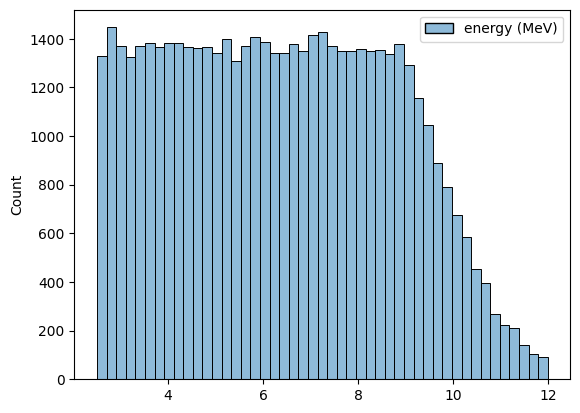

In [287]:
sn.histplot(df_energy_sig_train)

### Extracting test Data

In [288]:
#Separate signal from background 
dataset_sig_test = (df_test[df_test['IsNu'] == 1]).drop(columns=['Unnamed: 0'])
dataset_bkg_test = (df_test[df_test['IsTl'] == 1]).drop(columns=['Unnamed: 0'])

#cut in solar energy
dataset_sig_test = (dataset_sig_test[dataset_sig_test['energy (MeV)'] <= energy_cut_test])

#Separate Features for signal and background
df_pixel_sig_test = dataset_sig_test.filter(regex=pixel_pattern)
df_energy_sig_test = (dataset_sig_test[['energy (MeV)']])
df_radi_sig_test = (dataset_sig_test[['radius (mm)']])
df_label_sig_test = pd.DataFrame(dataset_sig_test, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_test = dataset_bkg_test.filter(regex=pixel_pattern)
df_energy_bkg_test= (dataset_bkg_test[['energy (MeV)']])
df_radi_bkg_test = (dataset_bkg_test[['radius (mm)']])
df_label_bkg_test = pd.DataFrame(dataset_bkg_test, columns = ['IsNu', 'IsTl'])

<Axes: ylabel='Count'>

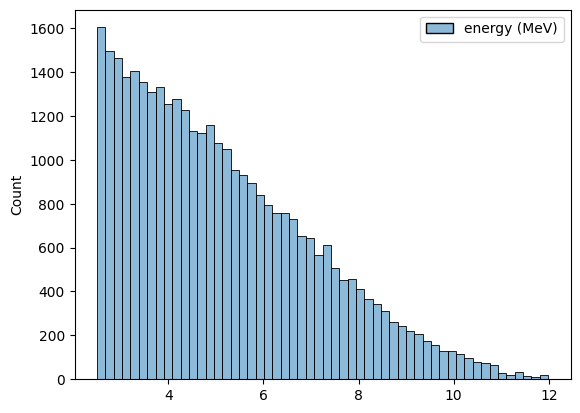

In [289]:
sn.histplot(df_energy_sig_test)

## 2.2 - Data Split (Train and Validation)
No necesario cuando esta aplicado en la red validation_slip

In [290]:
pixel_sig_train = df_pixel_sig_train
label_sig_train = df_label_sig_train
energy_sig_train = df_energy_sig_train
radi_sig_train = df_radi_sig_train

pixel_bkg_train = df_pixel_bkg_train
label_bkg_train = df_label_bkg_train
energy_bkg_train = df_energy_bkg_train
radi_bkg_train = df_radi_bkg_train

## 2.4 - Data Transformation

### 2.4.1 - Standard Scaler

In [291]:
# A Standard Scalar is used as transform, with a mean_value = 0 and std_deviation = 1

#This scaler is used in data we dont intend to recover in org. scale
scaler = StandardScaler()  

#Scalers applied to (energy, radius) of testing data, since we want to recover its org. representation
scaler_en_sig = StandardScaler()
scaler_en_bkg = StandardScaler()

scaler_rad_sig = StandardScaler()
scaler_rad_bkg = StandardScaler()

#std(Train):
pixel_sig_train_transf = scaler.fit_transform(pixel_sig_train)
pixel_bkg_train_transf = scaler.fit_transform(pixel_bkg_train)

energy_sig_train_transf = scaler.fit_transform(energy_sig_train).T[0]
energy_bkg_train_transf = scaler.fit_transform(energy_bkg_train).T[0]

radi_sig_train_transf = scaler.fit_transform(radi_sig_train).T[0]
radi_bkg_train_transf = scaler.fit_transform(radi_bkg_train).T[0]

#std(Validation):
#pixel_sig_val_transf = scaler.fit_transform(pixel_sig_val)
#pixel_bkg_val_transf = scaler.fit_transform(pixel_bkg_val)

#energy_sig_val_transf = scaler.fit_transform(energy_sig_val).T[0]
#energy_bkg_val_transf = scaler.fit_transform(energy_bkg_val).T[0]

#radi_sig_val_transf = scaler.fit_transform(radi_sig_val).T[0]
#radi_bkg_val_transf = scaler.fit_transform(radi_bkg_val).T[0]

#std(test):
pixel_sig_test_transf = scaler.fit_transform(df_pixel_sig_test)
pixel_bkg_test_transf = scaler.fit_transform(df_pixel_bkg_test)

energy_sig_test_transf = scaler_en_sig.fit_transform(df_energy_sig_test).T[0]
energy_bkg_test_transf = scaler_en_bkg.fit_transform(df_energy_bkg_test).T[0]

radi_sig_test_transf = scaler_rad_sig.fit_transform(df_radi_sig_test).T[0]
radi_bkg_test_transf = scaler_rad_bkg.fit_transform(df_radi_bkg_test).T[0]

Text(0.5, 1.0, 'Standardized Energy Distribution')

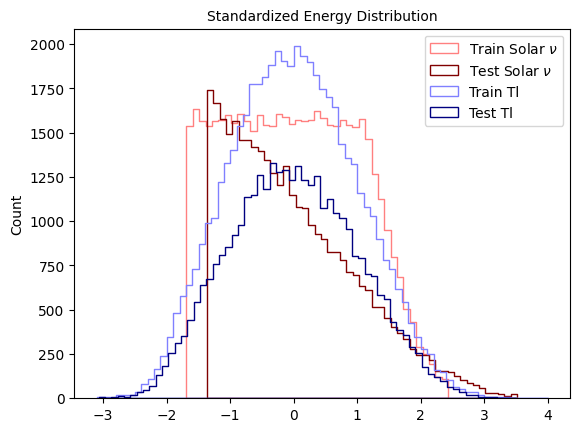

In [292]:
binwidth = 0.1
alpha = 0.0

sn.histplot(energy_sig_train_transf, binwidth = binwidth, alpha = alpha, color = variants['rojo'][0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(energy_sig_test_transf, binwidth = binwidth, alpha = alpha, color = variants['rojo'][1], element="step", label = 'Test Solar $ν$')
sn.histplot(energy_bkg_train_transf, binwidth = binwidth, alpha = alpha, color = variants['azul'][0], element="step", label = 'Train Tl')
sn.histplot(energy_bkg_test_transf, binwidth = binwidth, alpha = alpha, color = variants['azul'][1], element="step", label = 'Test Tl')

plt.legend()
plt.title('Standardized Energy Distribution', fontsize = 10)

Text(0.5, 1.0, 'Standardized Radial Distribution')

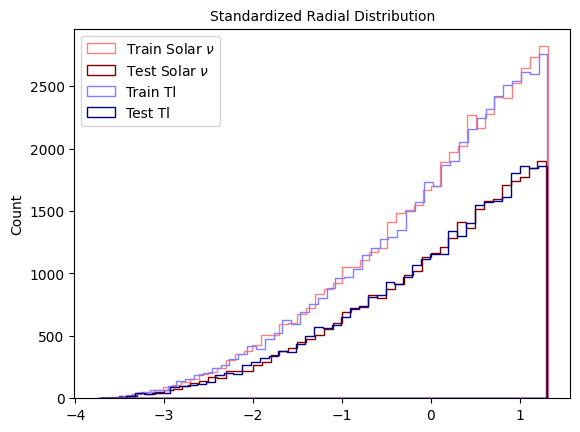

In [293]:
binwidth = 0.1
alpha = 0.0

sn.histplot(radi_sig_train_transf, binwidth = binwidth, alpha = alpha, color = variants['rojo'][0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_test_transf, binwidth = binwidth, alpha = alpha, color = variants['rojo'][1], element="step", label = 'Test Solar $ν$')
sn.histplot(radi_bkg_train_transf, binwidth = binwidth, alpha = alpha, color = variants['azul'][0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf, binwidth = binwidth, alpha = alpha, color = variants['azul'][1], element="step", label = 'Test Tl')

plt.legend(loc = 'upper left')
plt.title('Standardized Radial Distribution', fontsize = 10)

### 2.4.2 - Volume Normalization (radius)

In [221]:
vol = 5500**3

radi_sig_train_transf = (radi_sig_train**3)/vol
radi_bkg_train_transf = (radi_bkg_train**3)/vol

#radi_sig_val_transf = (radi_sig_val**3)/vol
#radi_bkg_val_transf = (radi_bkg_val**3)/vol

radi_sig_test_transf = (df_radi_sig_test**3)/vol
radi_bkg_test_transf = (df_radi_bkg_test**3)/vol

Text(0.5, 1.0, 'Normalization by Vol. - Radial Distribution')

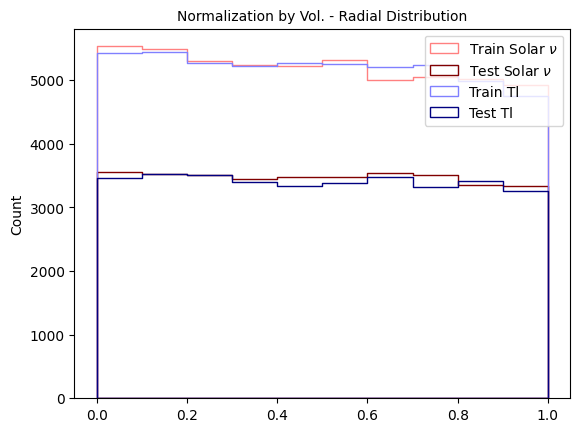

In [222]:
binwidth = 0.1
alpha = 0.0

sn.histplot(radi_sig_train_transf.values.T[0], binwidth = binwidth, alpha = alpha, color = variants['rojo'][0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_test_transf.values.T[0], binwidth = binwidth, alpha = alpha, color = variants['rojo'][1], element="step", label = 'Test Solar $ν$')
sn.histplot(radi_bkg_train_transf.values.T[0], binwidth = binwidth, alpha = alpha, color = variants['azul'][0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf.values.T[0], binwidth = binwidth, alpha = alpha, color = variants['azul'][1], element="step", label = 'Test Tl')

plt.legend()
plt.title('Normalization by Vol. - Radial Distribution', fontsize = 10)

### 2.4.3 - Standard Scaler of Volume Normalization

CUIDADOQUE SE HAN REDEFINIDO VARIABLE CON SU PROPIO NOMBRE!

In [242]:
scaler_rad_sig = StandardScaler()
scaler_rad_bkg = StandardScaler()

radi_sig_train_transf = scaler.fit_transform(radi_sig_train_transf).T[0]
radi_bkg_train_transf = scaler.fit_transform(radi_bkg_train_transf).T[0]

radi_sig_test_transf = scaler_rad_sig.fit_transform(radi_sig_test_transf).T[0]
radi_bkg_test_transf = scaler_rad_bkg.fit_transform(radi_bkg_test_transf).T[0]

Text(0.5, 1.0, 'Standardized Vol. Normalization - Radial Distribution')

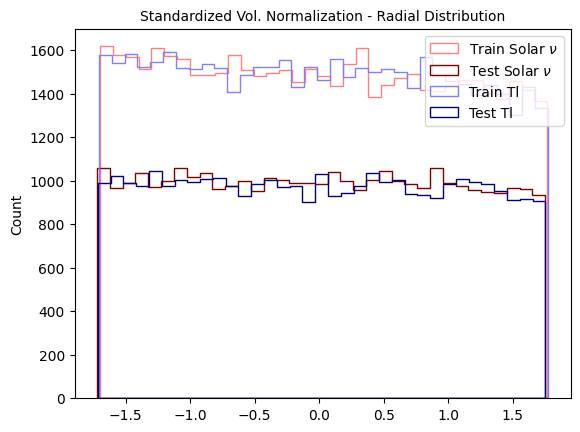

In [243]:
binwidth = 0.1
alpha = 0.0

sn.histplot(radi_sig_train_transf, binwidth = binwidth, alpha = alpha, color = variants['rojo'][0], element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_test_transf, binwidth = binwidth, alpha = alpha, color = variants['rojo'][1], element="step", label = 'Test Solar $ν$')
sn.histplot(radi_bkg_train_transf, binwidth = binwidth, alpha = alpha, color = variants['azul'][0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf, binwidth = binwidth, alpha = alpha, color = variants['azul'][1], element="step", label = 'Test Tl')

plt.legend()
plt.title('Standardized Vol. Normalization - Radial Distribution', fontsize = 10)

In [155]:
radi_sig_train_transf

array([-0.60680829,  0.37380427, -0.33884239, ..., -1.20912492,
       -0.48377483, -1.38527815])

## 2.5 - Unify DataSets

In [294]:
#Unify datasets

pixel_train = np.concatenate((pixel_sig_train_transf, pixel_bkg_train_transf))
energy_train = np.concatenate((energy_sig_train_transf, energy_bkg_train_transf))
radi_train = np.concatenate((radi_sig_train_transf, radi_bkg_train_transf))#.T[0]
label_train = np.concatenate((label_sig_train, label_bkg_train))

#pixel_val = np.concatenate((pixel_sig_val_transf, pixel_bkg_val_transf))
#energy_val = np.concatenate((energy_sig_val_transf, energy_bkg_val_transf))
#radi_val = np.concatenate((radi_sig_val_transf, radi_bkg_val_transf)).T[0]
#label_val = np.concatenate((label_sig_val, label_bkg_val))

pixel_test = np.concatenate ((pixel_sig_test_transf, pixel_bkg_test_transf))
energy_test = np.concatenate((energy_sig_test_transf, energy_bkg_test_transf))
radi_test = np.concatenate((radi_sig_test_transf, radi_bkg_test_transf))#.T[0]
label_test = np.concatenate((df_label_sig_test, df_label_bkg_test))

In [295]:
radi_train

array([ 0.39856233, -0.45418136,  0.38399401, ..., -1.7855548 ,
        1.27776793,  0.04660057])

# 3 - Model Construction and Evaluation
https://keras.io/guides/functional_api/

- Agregar camadas de información principal
- Agregar información auxiliar (energia, radio)

## 3.1 - Model Layers, compilation and fit

In [312]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

input_image = Input(shape = (100,), name = 'image_input')
input_energy = Input(shape = (1,), name = 'energy_input')
input_rad = Input(shape = (1,), name = 'radius_input')

image_ly = Dense(50, activation = None, name = 'im_ly_1')(input_image)
image_ly = Dense(30, activation = 'gelu', name = 'im_ly_2')(image_ly)

energy_ly = Dense(50, activation = None, name = 'en_ly_1')(input_energy)
energy_ly = Dense(20, activation = 'gelu', name = 'en_ly_2')(energy_ly)

radial_ly = Dense(50, activation = None, name = 'rad_ly_1')(input_rad)
radial_ly = Dense(40, activation = 'gelu', name = 'rad_ly_2')(radial_ly)

x = concatenate([image_ly, energy_ly,radial_ly])
x = Dense(50, activation = 'gelu')(x)
x = Dropout(rate = 0.2)(x)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

model = Model(inputs = [input_image, input_energy, input_rad], outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['AUC', 'accuracy'])

#Tensorboard usage:
logdir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train}, 
                    y = {'nu_predict':label_train}, 
                    epochs = 50, 
                    batch_size = 100,
                    validation_split = 0.3,
                    #validation_data = ({'image_input': pixel_val, 'energy_input': energy_val, 'radius_input': radi_val}, label_val),
                    shuffle = True,
                    callbacks=[tensorboard_callback])

Epoch 1/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7297 - accuracy: 0.7003 - loss: 0.6057 - val_AUC: 0.0709 - val_accuracy: 0.1456 - val_loss: 1.1046
Epoch 2/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8470 - accuracy: 0.7695 - loss: 0.4833 - val_AUC: 0.9258 - val_accuracy: 0.8360 - val_loss: 0.3441
Epoch 3/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9718 - accuracy: 0.9090 - loss: 0.2167 - val_AUC: 0.9493 - val_accuracy: 0.8449 - val_loss: 0.2878
Epoch 4/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9886 - accuracy: 0.9403 - loss: 0.1376 - val_AUC: 0.9709 - val_accuracy: 0.8837 - val_loss: 0.2130
Epoch 5/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9926 - accuracy: 0.9519 - loss: 0.1106 - val_AUC: 0.9594 - val_accuracy: 0.8517 - val_loss: 0.2779
Epoch 6/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9935 - accuracy: 0.9555 - loss: 0.1025 - val_AUC: 0.9657 - val_accuracy: 0.8652 - val_loss: 0.2473
Epoch 7/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 

## 3.2 - Train and Validation Progress

Text(0.5, 0.98, 'Train and Validation Progress - Energy : [2.5,8] MeV - R < 5500 (mm)')

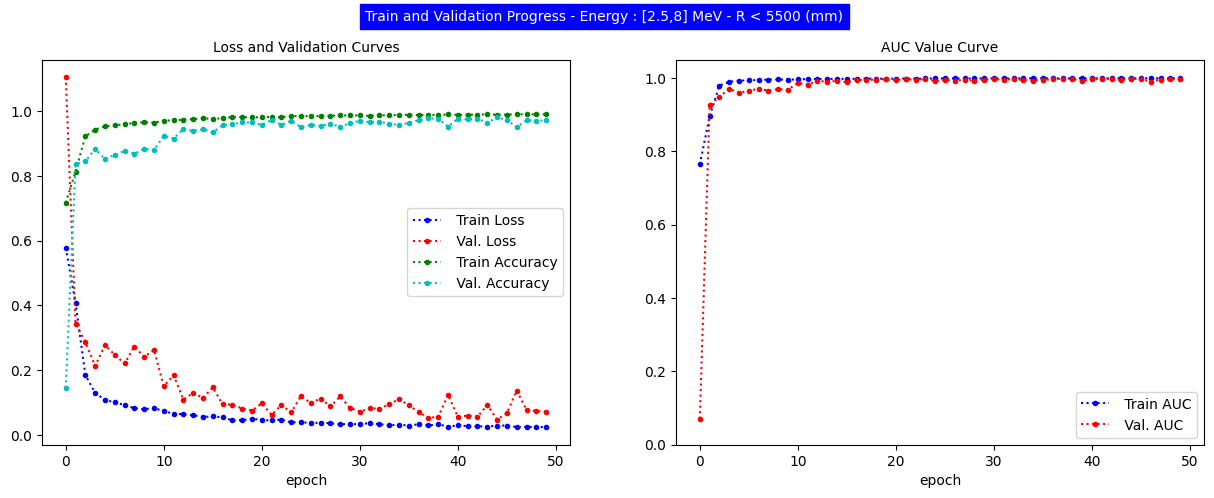

In [313]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

axes[1].set_ylim(0, 1.05)


fig.suptitle('Train and Validation Progress - Energy : [2.5,8] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
#plt.savefig('figs/First Model/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')

## 3.3 - Save/Load Model

## 3.4 - Observation and Analysis of Predictions

### 3.4.1 - NN Prediction

In [314]:
X_sig_pred = model.predict([pixel_sig_test_transf, energy_sig_test_transf, radi_sig_test_transf])
X_bkg_pred = model.predict([pixel_bkg_test_transf, energy_bkg_test_transf, radi_bkg_test_transf])

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step


### 3.4.2 - Analysis of Predictions

In [316]:
X_sig_pred

array([[1.0000000e+00, 1.9253207e-11],
       [9.9523032e-01, 4.7504702e-03],
       [9.9631947e-01, 3.7249830e-03],
       ...,
       [1.0000000e+00, 5.7059653e-23],
       [1.0000000e+00, 1.9372357e-16],
       [9.9999964e-01, 3.7786131e-07]], dtype=float32)

In [300]:
X_bkg_pred

array([[1.6235456e-21, 1.0000000e+00],
       [8.1405618e-11, 1.0000000e+00],
       [7.5538364e-06, 9.9999243e-01],
       ...,
       [3.3168382e-13, 1.0000000e+00],
       [1.2700246e-12, 1.0000000e+00],
       [2.3555052e-21, 1.0000000e+00]], dtype=float32)

In [317]:
print('working with ' + str(len(X_sig_pred)) + ' of signal and ' + str(len(X_bkg_pred)) + ' of background as testing data')

working with 34699 of signal and 34720 of background as testing data


### 3.4.3 - Representation of Predictions

#### Distribution of Probabilities

Text(0.5, 0.98, 'Model Predictions for Solar $ν$ events and Background events - Energy : [2.5,12] MeV - R < 5500 (mm)')

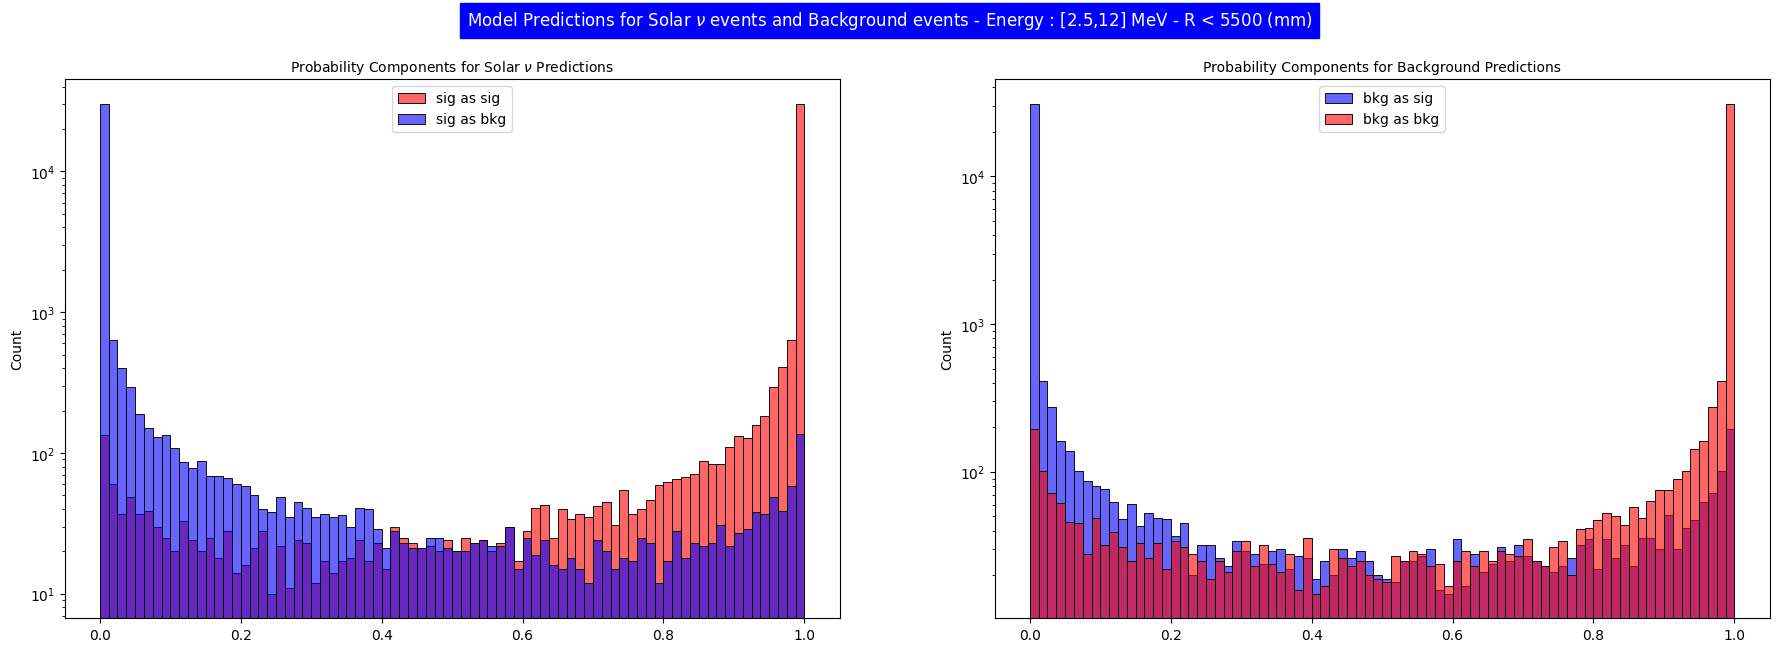

In [318]:
sn.reset_orig
bins = 80
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'sig as sig', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'sig as bkg', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'bkg as sig',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'bkg as bkg', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'upper center')
axes[1].legend(loc = 'upper center')
plt.suptitle('Model Predictions for Solar $ν$ events and Background events - Energy : [2.5,12] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
#plt.savefig('figs/First Model/10x10/probability_predictions1.png', format = 'png', bbox_inches = 'tight')

### 3.4.4 - ROC Curve

In [319]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))        #Predicted
X_exp = np.concatenate((df_label_sig_test, df_label_bkg_test)) #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

Text(0.5, 0.98, 'ROC curve for Model Predictions - Energy : [2.5,12] MeV - R < 5500 (mm)')

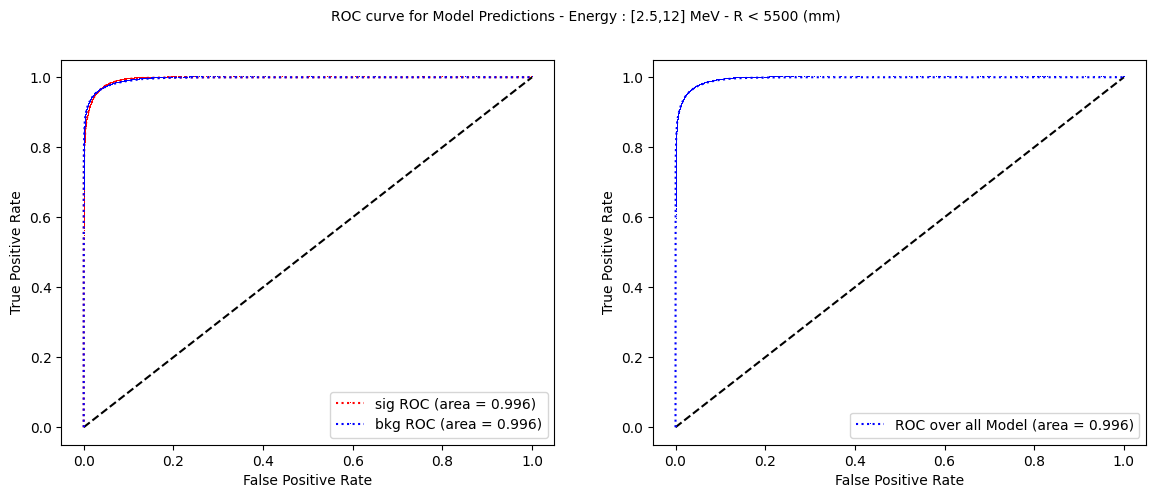

In [320]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.3f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.3f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.3f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle('ROC curve for Model Predictions - Energy : [2.5,12] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/First Model/10x10/ROC.png', format = 'png', bbox_inches = 'tight')

### 3.4.5 - Reconstrucción de espector de solar $ν_e$ e de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

#### Recuperar Valores de Energia y Radio (Inverse Standard Scaler)

In [321]:
energy_sig_rc = scaler_en_sig.inverse_transform([energy_sig_test_transf])[0]
energy_bkg_rc = scaler_en_bkg.inverse_transform([energy_bkg_test_transf])[0]

radi_sig_rc = scaler_rad_sig.inverse_transform([radi_sig_test_transf])[0]
radi_bkg_rc = scaler_rad_bkg.inverse_transform([radi_bkg_test_transf])[0]

#### Recuperar Valores de Radio apartir del Volumen

In [152]:
radi_sig_rc = np.cbrt(radi_sig_rc*vol)#.to_numpy().T[0]
radi_bkg_rc = np.cbrt(radi_bkg_rc*vol)#.to_numpy().T[0]

In [322]:
max(energy_sig_rc)

11.983275413513184

In [202]:
radi_sig_rc

array([5216.24462891, 1323.85375977, 3336.62280273, ..., 5476.10253906,
       4872.55517578, 4624.76953125])

In [323]:
threshold_p = 0.90  #definition of probability treshold to pick valid predictions (90% of solar nu)

nu_energy_in_spectrum = []
nu_energy_out_spectrum = []

tl_energy_in_spectrum = []
tl_energy_out_spectrum = []

for i in np.where(X_sig_pred[:,0] >= threshold_p)[0]:
    nu_energy_in_spectrum.append(energy_sig_rc[i])
    
for j in np.where(X_sig_pred[:,0] < threshold_p)[0]:
    nu_energy_out_spectrum.append(energy_sig_rc[j])

for m in np.where(X_bkg_pred[:,1] >= threshold_p)[0]:
    tl_energy_in_spectrum.append(energy_bkg_rc[m])

for k in np.where(X_bkg_pred[:,1] < threshold_p)[0]:
    tl_energy_out_spectrum.append(energy_bkg_rc[k])
    
nu_energy_in_spectrum = np.array(nu_energy_in_spectrum)
nu_energy_out_spectrum = np.array(nu_energy_out_spectrum)
tl_energy_in_spectrum = np.array(tl_energy_in_spectrum)
tl_energy_out_spectrum = np.array(tl_energy_out_spectrum)

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
C:\Users\joanc\AppData\Local\Temp\ipykernel_17108\3392119498.py:13: SyntaxWarning: invalid escape sequence '\g'
  sn.histplot(nu_energy_in_spectrum, bins = bins, color = variants['rojo'][0] , label = 'Energy for $P(ν_e) \geq$ trh',


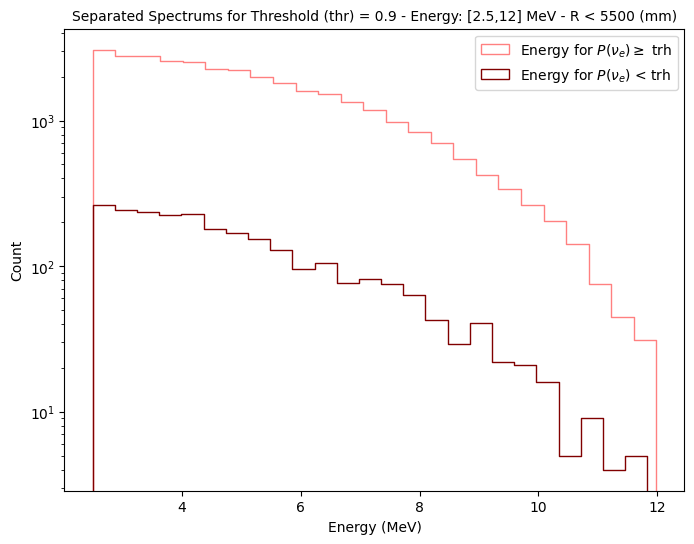

In [324]:
bins = 25
alpha_en_in = 0.0
alpha_en_out = 0.0
linewidth_en = 1.0

plt.figure(figsize =(8, 6))

#sn.histplot(tl_energy_in_spectrum, bins = bins, color = variants['azul'][0], label = 'Energy for $P(Tl) \geq$ trh', 
#            alpha = alpha_en_in, linewidth = linewidth_en, element = 'step')
#sn.histplot(tl_energy_out_spectrum, bins = bins, color = variants['azul'][1], label = 'Energy for $P(Tl)$ < trh', 
#            alpha = alpha_en_out, linewidth = linewidth_en, element = 'step')

sn.histplot(nu_energy_in_spectrum, bins = bins, color = variants['rojo'][0] , label = 'Energy for $P(ν_e) \geq$ trh', 
            alpha = alpha_en_in, linewidth = linewidth_en, element = 'step')
sn.histplot(nu_energy_out_spectrum, bins = bins, color = variants['rojo'][1], label = 'Energy for $P(ν_e)$ < trh', 
            alpha = alpha_en_out, linewidth = linewidth_en, element = 'step')

#sn.histplot(energy_sig, bins = 20, color = 'r', label = 'All Solar $ν_e$ Spectrum', alpha = 0, linewidth = linewidth_en, element = 'step', kde = False)
plt.xlabel('Energy (MeV)')
plt.legend(loc = 'best')
plt.title('Separated Spectrums for Threshold (thr) = ' + str(threshold_p) + ' - Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 10)
plt.yscale('log')
#plt.xlim(2.5,8)
#plt.savefig('figs/First Model/10x10/effic_in_energy_pred_th.png', format = 'png', bbox_inches = 'tight')
plt.show()

### 3.4.6 - Efficience curve of predictions

Representar curva de eficiencia de las prediciones del modelo (sig=X_pred[:0], bkg=X_pred[:1]) en función de la energia y el radio del evento

In [172]:
#Efficiencia = Prob. de estar correcta la prediccion
X_sig_eff = X_sig_pred[:,0]
X_bkg_eff = X_bkg_pred[:,1]

x = np.concatenate((energy_sig_rc, energy_bkg_rc))
y = np.concatenate((radi_sig_rc, radi_bkg_rc))
z = np.concatenate((X_sig_eff, X_bkg_eff))

Text(0.5, 1.0, 'Model Efficiency of classification $ε$ as function of $(E,R)$')

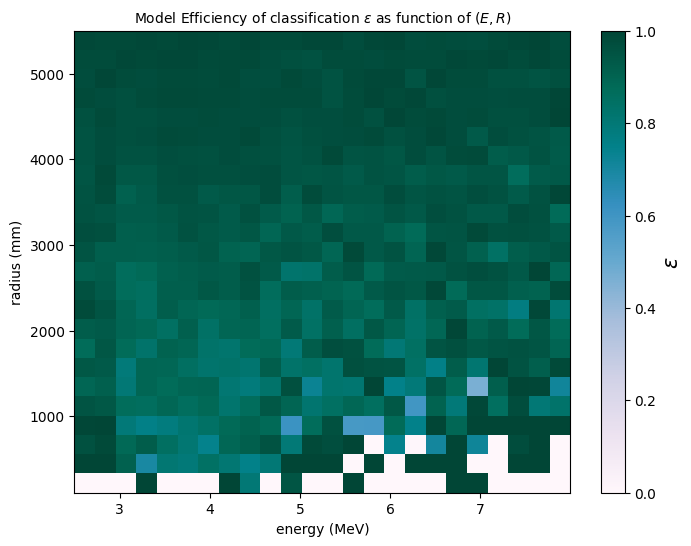

In [173]:
bins = 25

# Definir los límites y número de bins
x_edges = np.linspace(x.min(), x.max(), bins)
y_edges = np.linspace(y.min(), y.max(), bins)

# Inicializar una matriz para almacenar los valores de z
hist = np.zeros((len(x_edges)-1, len(y_edges)-1))

# Calcular los valores de z en cada bin
for i in range(len(x_edges)-1):
    for j in range(len(y_edges)-1):
        mask = (x >= x_edges[i]) & (x < x_edges[i+1]) & (y >= y_edges[j]) & (y < y_edges[j+1])
        if np.sum(mask) > 0:
            hist[i, j] = np.mean(z[mask])  # Otras estadísticas podrían ser np.sum, np.median, etc.

# Crear el plot
fig, ax = plt.subplots(figsize=(8,6))
c = ax.pcolormesh(x_edges, y_edges, hist.T, shading='auto', cmap = cm.PuBuGn)
cbar = fig.colorbar(c, ax=ax)

# Agregar un título a la barra de color
cbar.set_label('$ε$', fontsize = 15)

ax.set_xlabel('energy (MeV)')
ax.set_ylabel('radius (mm)')
ax.set_title('Model Efficiency of classification $ε$ as function of $(E,R)$', fontsize = 10)
#plt.xlim(2,10)
#plt.ylim(0,5500)
#plt.savefig('figs/First Model/10x10/Eff_of_clasification(E,R).png', format = 'png', bbox_inches = 'tight')

### 3.4.7 - Normalized Efficiency by N_Counts(true)

Construir un plot de eficicencia normalizada por el numero total de eventos en un bin del plot "Separated Spectrums for Threshold (trh)".
Procedimientos de construcción:

1) extraer valores de energia contenidos en cada bin de "Separated Spectrums for Threshold (trh)"
2) Contabilizar el nº de eventos que superan el treshold dentro del bin de energia, y dividir por el número de eventos contenido en el bin, esta será la eficiencia normalizado por N_events_true
3) Hacer plot de la eficiciencia normalizada en funcion del valor medio de las energias contenida en el bin (cuanto mas bins, mas puntos de eficiencia habra)

In [325]:
#Information to save -------------------------------
norm_eff = np.array([])
mean_energy = np.array([])  #mean energy values for each bin

#Information to use: --------------------------------
#Extract predictions for solar nu in the solar_nu component
prob_nu = X_sig_pred[:,0]
#construct binned data
en_sig_test_count, en_sig_test_edge = np.histogram(energy_sig_rc, bins = bins)
# --------------------------------------------------

N_edges_sig = len(en_sig_test_edge)

for i in range(N_edges_sig-1):
    #extract edges value of energy at each bin
    energy_edge_i = en_sig_test_edge[i]
    energy_edge_f = en_sig_test_edge[i+1]

    #find energy in energy_test_sig between edges values is and the model prediction
    energy_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc<=energy_edge_f), energy_sig_rc)
    prob_nu_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc<=energy_edge_f), prob_nu)

    #extract mean energy of binned interval
    mean_energy_interval = np.mean(energy_interval)
    mean_energy = np.append(mean_energy, mean_energy_interval)
    
    #Total Number of events we know are true
    N_true = len(prob_nu_interval)

    #find where prob. is higher than threshold and count
    condition_thr = prob_nu_interval >= threshold_p
    energy_up_thr = np.extract(condition_thr, energy_interval)
    N_up_thr = len(energy_up_thr)

    #compute normalized efficiency
    norm_eff_interval = N_up_thr / N_true
    norm_eff = np.append(norm_eff, norm_eff_interval)

(0.85, 1.0)

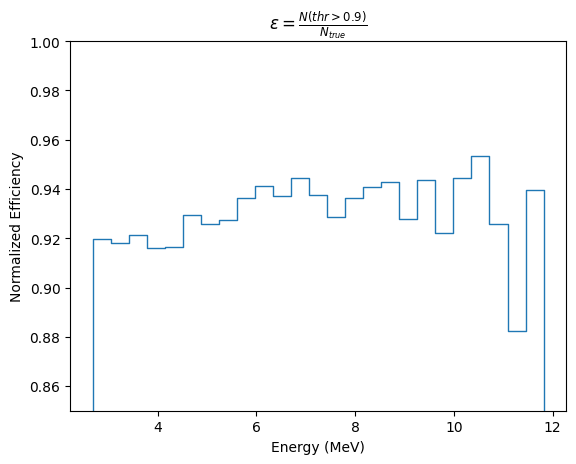

In [327]:
sn.histplot(x=mean_energy, bins=len(mean_energy), weights=norm_eff, element = 'step', alpha = 0.0)
plt.title(r'$\epsilon = \frac{N(thr > '+str(threshold_p)+')}{N_{true}}$')
plt.xlabel('Energy (MeV)')
plt.ylabel('Normalized Efficiency')
plt.ylim(0.85, 1)